# Configure Merge Module Params

This notebook should be used as a test for ensuring correct merge parameters before merge processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for merge processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [56]:
CONFIG_FILE_PATH = "config/config.yml"

In [57]:
import warnings
from pathlib import Path
import yaml
import pandas as pd

from lib.shared.file_utils import get_filename
from lib.shared.configuration_utils import CONFIG_FILE_HEADER, convert_tuples_to_lists
from lib.merge.merge_utils import (
    plot_combined_tile_grid,
    plot_merge_example,
    preview_mask_transformations,
    align_metadata,
    find_closest_tiles,
    fast_merge_example,
)
from lib.merge.hash import hash_cell_locations, initial_alignment
from lib.merge.eval_alignment import plot_alignment_quality

## <font color='red'>SET PARAMETERS</font>

### Determine merge plate-well combos
- `MERGE_COMBO_DF_FP`: Plate used for testing configuration

In [58]:
MERGE_COMBO_DF_FP = "config/merge_combo.tsv"

In [59]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

SBS_COMBO_FP = Path(config["preprocess"]["sbs_combo_fp"])
sbs_wildcard_combos = pd.read_csv(SBS_COMBO_FP, sep="\t")
PHENOTYPE_COMBO_FP = Path(config["preprocess"]["phenotype_combo_fp"])
phenotype_wildcard_combos = pd.read_csv(PHENOTYPE_COMBO_FP, sep="\t")

# Subset phenotype combos to only those in plate 1
phenotype_wildcard_combos = phenotype_wildcard_combos[
    phenotype_wildcard_combos["plate"] == 1
]

# Generate plate-well combinations for merge
sbs_combos = set(zip(sbs_wildcard_combos["plate"], sbs_wildcard_combos["well"]))
phenotype_combos = set(
    zip(phenotype_wildcard_combos["plate"], phenotype_wildcard_combos["well"])
)

# Check if SBS and PHENOTYPE have the same plate-well combinations
if sbs_combos == phenotype_combos:
    merge_wildcard_combos = pd.DataFrame(list(sbs_combos), columns=["plate", "well"])
else:
    warnings.warn(
        "SBS and PHENOTYPE do not have matching plate-well combinations. Merging requires identical sets."
    )
    merge_wildcard_combos = pd.DataFrame(columns=["plate", "well"])

merge_wildcard_combos.to_csv(MERGE_COMBO_DF_FP, sep="\t", index=False)
merge_wildcard_combos

,plate,well
0,1,B1
1,1,A1
2,1,B3
3,1,B2
4,1,A2
5,1,A3


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge module
- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration 

### Parameters for metadata extraction
- `SBS_METADATA_CYCLE`: Cycle number for extracting SBS data positions from the combined metadata file
- `SBS_METADATA_CHANNEL`: Optional channel filter for SBS metadata. Use this to filter the combined metadata file to a specific channel when multiple channels were acquired. If not specified, metadata will be automatically deduplicated by plate, well, and tile.
- `PH_METADATA_CHANNEL`: Optional channel filter for phenotype metadata. Use this to filter the combined metadata file to a specific channel when multiple channels were acquired. If not specified, metadata will be automatically deduplicated by plate, well, and tile.

In [60]:
# CROSS-PLATE MATCHING: Use P2 phenotype with P1 SBS
TEST_PLATE = 1  # Used for SBS
TEST_WELL = "A2"
PHENOTYPE_PLATE = 2  # Use plate 2 for phenotype data

SBS_METADATA_CYCLE = 1
SBS_METADATA_CHANNEL = None
PH_METADATA_CHANNEL = None

=== CROSS-PLATE MATCHING ===
Phenotype: Plate 2, Well A2 - 1,374,761 cells, 1693 tiles
SBS: Plate 1, Well A2 - 1,401,190 cells, 76 tiles


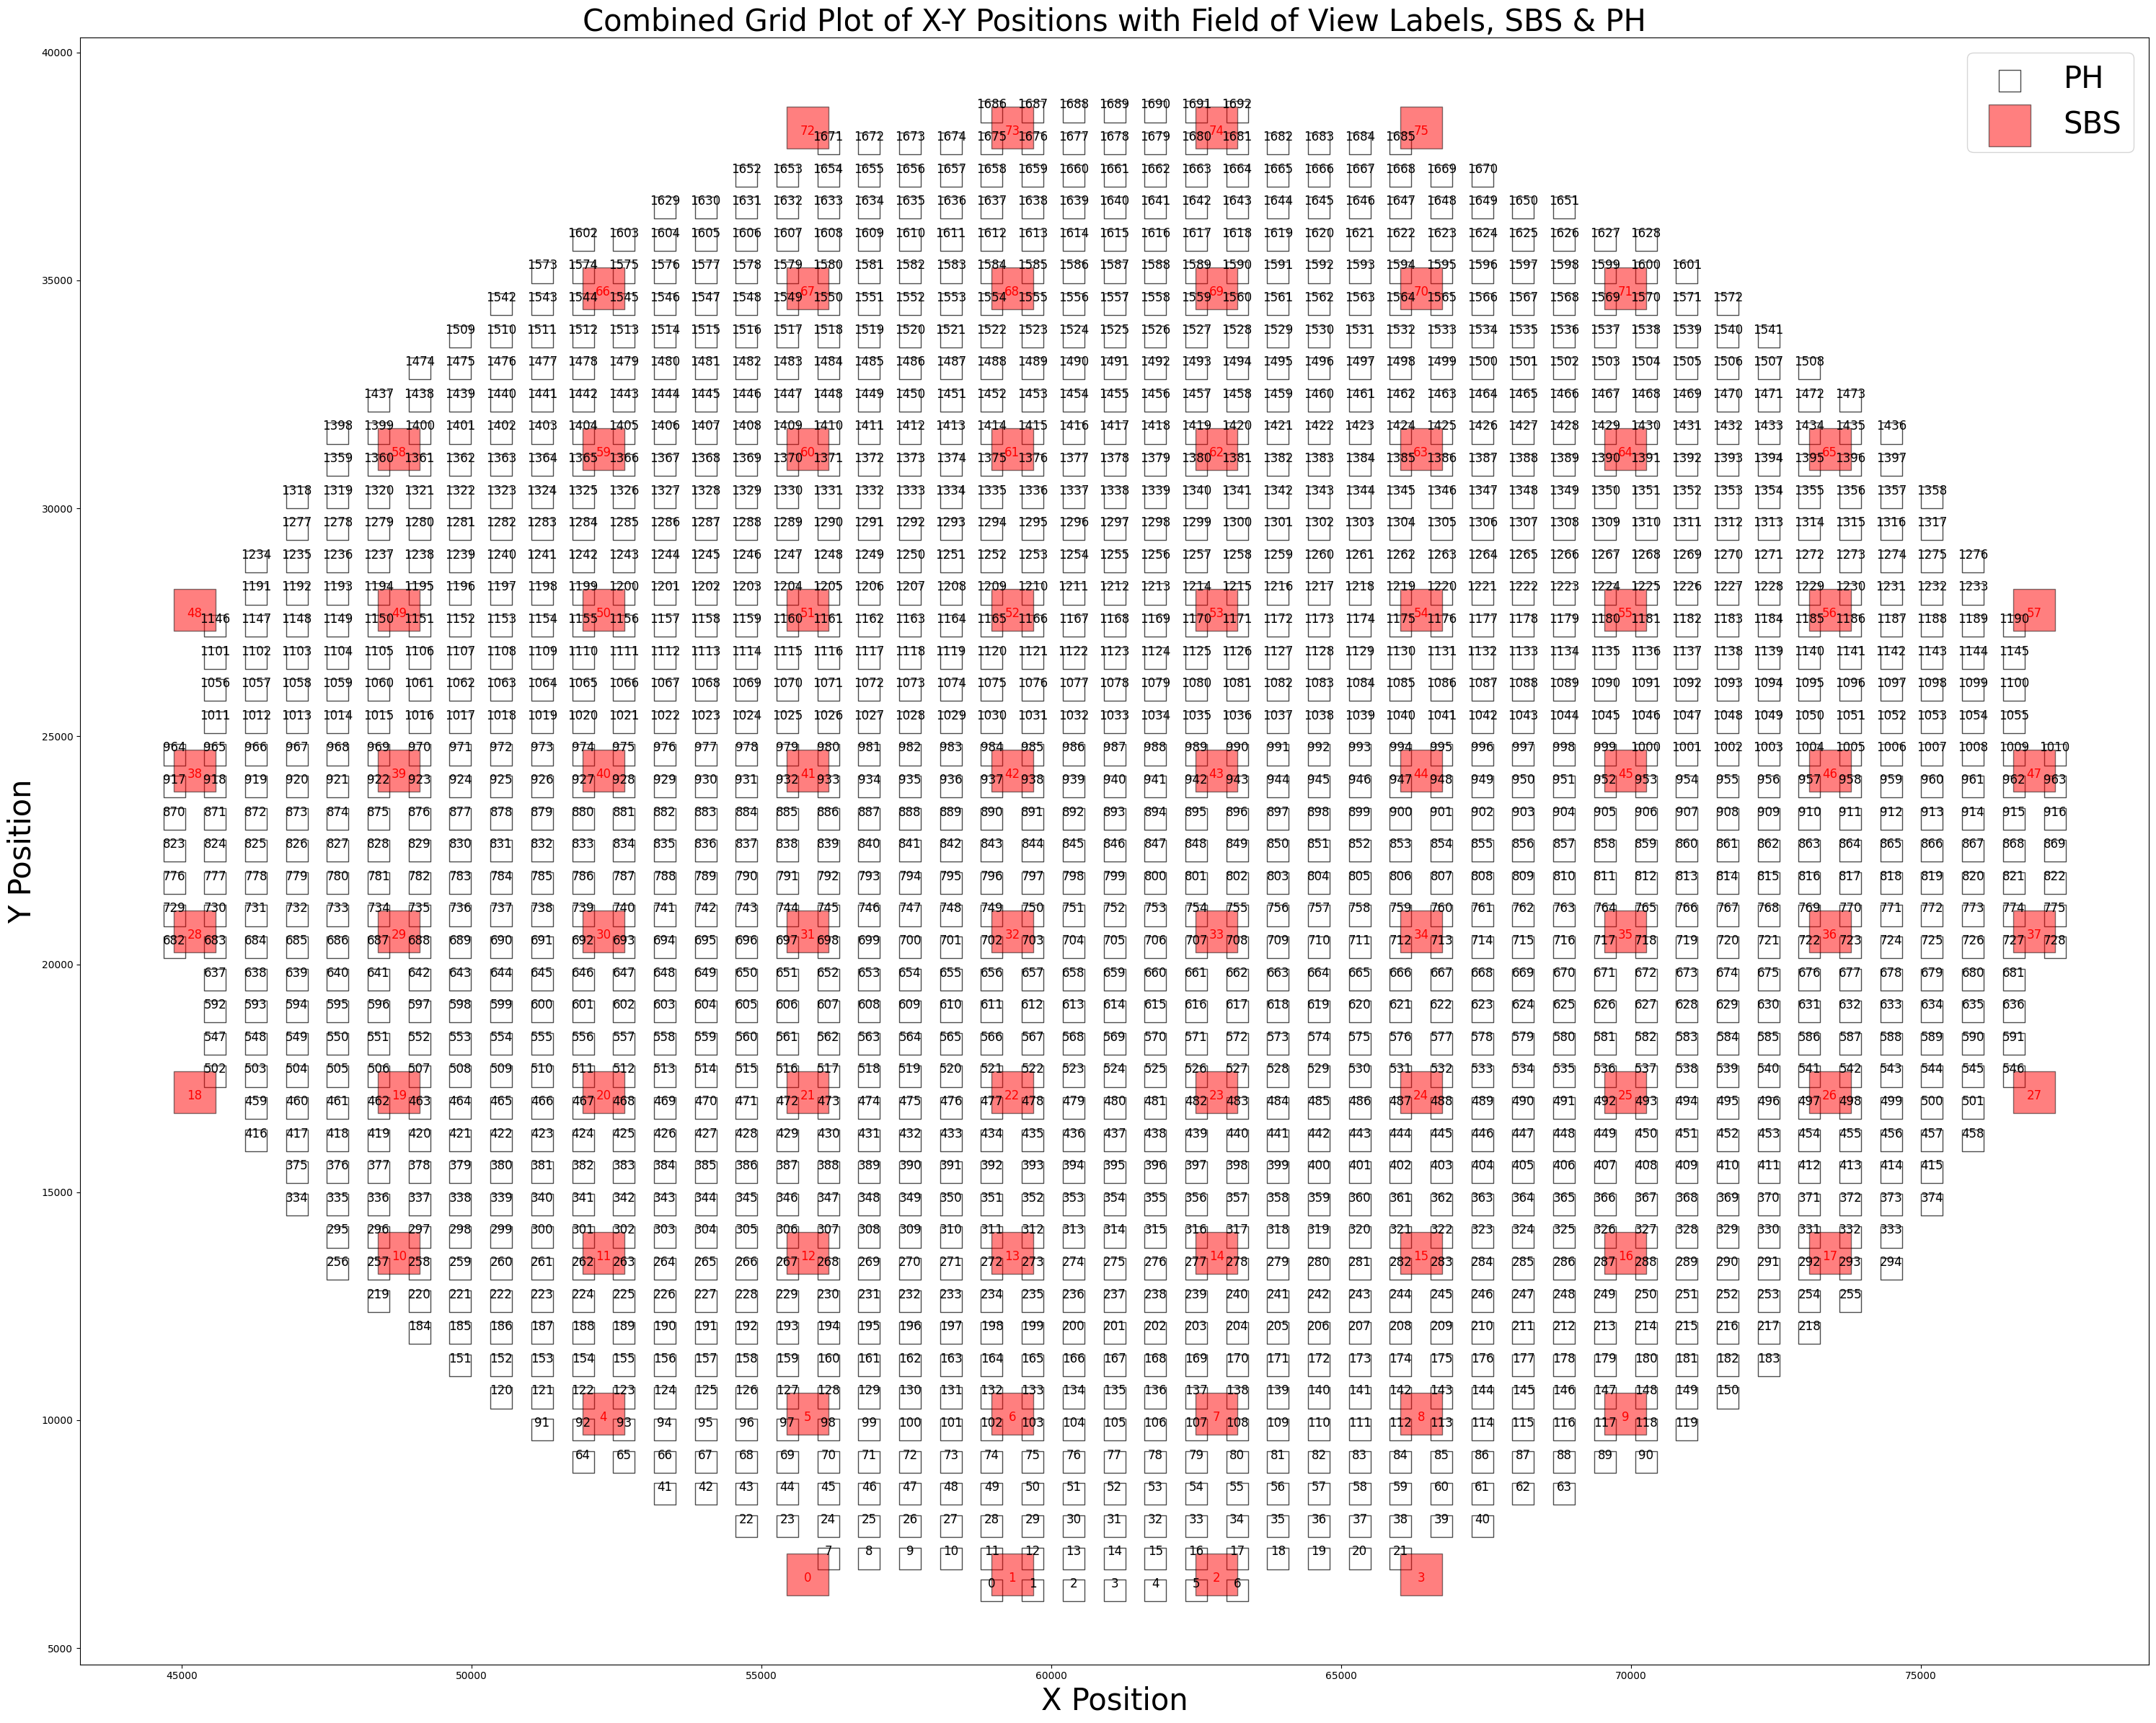

In [61]:
ROOT_FP = Path(config["all"]["root_fp"])

# load phenotype metadata using PHENOTYPE_PLATE
ph_filename_params = {"plate": PHENOTYPE_PLATE, "well": TEST_WELL}
if PH_METADATA_CHANNEL is not None:
    ph_filename_params["channel"] = PH_METADATA_CHANNEL

ph_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "phenotype"
    / get_filename(ph_filename_params, "combined_metadata", "parquet")
)
ph_test_metadata = pd.read_parquet(ph_test_metadata_fp)

# Apply phenotype channel filtering if specified, otherwise deduplicate
if PH_METADATA_CHANNEL is not None:
    ph_test_metadata = ph_test_metadata[ph_test_metadata["channel"] == PH_METADATA_CHANNEL]
else:
    ph_test_metadata = ph_test_metadata.drop_duplicates(subset=["plate", "well", "tile"])

# load SBS metadata using TEST_PLATE
sbs_filename_params = {"plate": TEST_PLATE, "well": TEST_WELL}
if SBS_METADATA_CHANNEL is not None:
    sbs_filename_params["channel"] = SBS_METADATA_CHANNEL

sbs_test_metadata_fp = (
    ROOT_FP
    / "preprocess"
    / "metadata"
    / "sbs"
    / get_filename(sbs_filename_params, "combined_metadata", "parquet")
)
sbs_test_metadata = pd.read_parquet(sbs_test_metadata_fp)

# Apply SBS filtering - always filter by cycle, optionally by channel, otherwise deduplicate
sbs_test_metadata = sbs_test_metadata[sbs_test_metadata["cycle"] == SBS_METADATA_CYCLE]
if SBS_METADATA_CHANNEL is not None:
    sbs_test_metadata = sbs_test_metadata[sbs_test_metadata["channel"] == SBS_METADATA_CHANNEL]
else:
    sbs_test_metadata = sbs_test_metadata.drop_duplicates(subset=["plate", "well", "tile"])

# Load phenotype info using PHENOTYPE_PLATE
phenotype_info_fp = (
    ROOT_FP
    / "phenotype"
    / "parquets"
    / get_filename(
        {"plate": PHENOTYPE_PLATE, "well": TEST_WELL}, "phenotype_info", "parquet"
    )
)
phenotype_info = pd.read_parquet(phenotype_info_fp)

# Load SBS info using TEST_PLATE
sbs_info_fp = (
    ROOT_FP
    / "sbs"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "sbs_info", "parquet")
)
sbs_info = pd.read_parquet(sbs_info_fp)

print(f"=== CROSS-PLATE MATCHING ===")
print(f"Phenotype: Plate {PHENOTYPE_PLATE}, Well {TEST_WELL} - {len(phenotype_info):,} cells, {phenotype_info['tile'].nunique()} tiles")
print(f"SBS: Plate {TEST_PLATE}, Well {TEST_WELL} - {len(sbs_info):,} cells, {sbs_info['tile'].nunique()} tiles")

# create plot with combined tile view
combined_tile_grid = plot_combined_tile_grid(ph_test_metadata, sbs_test_metadata)
combined_tile_grid.show()

## <font color='red'>SET PARAMETERS</font>

### Parameters for metadata alignment
Each microscope handles global coordinates differently. If datasets were acquired in two different microscopes the metadata of the wells needs to be aligned.

`METADATA_ALIGN`: Whether to perform metadata alignment. Defaults `False`.

`ALIGNMENT_FLIP_X`: Flip images left-to-right (horizontal flip). Defaults `False`.

`ALIGNMENT_FLIP_Y`: Flip images up-down (vertical flip). Defaults `False`.

`ALIGNMENT_ROTATE_90`: Whether to rotate 90 degrees counterclockwise. Defaults `False`.

In [62]:
METADATA_ALIGN = False
ALIGNMENT_FLIP_X = False
ALIGNMENT_FLIP_Y = False
ALIGNMENT_ROTATE_90_CW = False
ALIGNMENT_ROTATE_90_CCW = False

In [63]:
# Apply flip and rotate transformation
if METADATA_ALIGN:
    sbs_aligned, ph_aligned, transform_info = align_metadata(
        sbs_test_metadata, ph_test_metadata, 
        flip_x=ALIGNMENT_FLIP_X,     # Flip x coordinates (horizontal flip)
        flip_y=ALIGNMENT_FLIP_Y,    # Flip y coordinates (vertical flip)
        rotate_90_cw=ALIGNMENT_ROTATE_90_CW,   # Rotate 90 degrees clockwise
        rotate_90_ccw=ALIGNMENT_ROTATE_90_CCW, # Rotate 90 degrees counterclockwise
    )
    # Check the result with your combined tile grid
    combined_tile_grid = plot_combined_tile_grid(ph_aligned, sbs_aligned)
    combined_tile_grid.show()
else:
    sbs_aligned = sbs_test_metadata
    ph_aligned = ph_test_metadata

In [64]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# def plot_global_cell_positions(info, metadata):
#     """
#     Plot cell positions (i,j) at their global tile locations (x_pos, y_pos).
    
#     Args:
#         info (pd.DataFrame): Info data with 'i', 'j', 'tile' columns (cell positions within tiles)
#         metadata (pd.DataFrame): Metadata with 'x_pos', 'y_pos', 'tile' columns (tile positions)
#     """
#     # Merge info and metadata to get global positions
#     merged = info.merge(metadata[['tile', 'x_pos', 'y_pos']], on='tile', how='left')
    
#     # Calculate global cell positions
#     # i is the column (x direction), j is the row (y direction)
#     merged['global_x'] = merged['x_pos'] + merged['i']
#     merged['global_y'] = merged['y_pos'] + merged['j']
    
#     # Create the plot
#     fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    
#     # Plot all cells as small dots
#     ax.scatter(merged['global_x'], merged['global_y'], 
#                s=0.1, alpha=0.3, c='red', label=f'Cells ({len(merged)} total)')
    
#     # Plot tile numbers at tile centers
#     for _, tile_row in metadata.iterrows():
#         # Get cells for this tile to calculate dimensions
#         tile_cells = merged[merged['tile'] == tile_row['tile']]
        
#         if len(tile_cells) > 0:
#             # Calculate tile center from mean of cell positions
#             tile_center_x = tile_cells['global_x'].mean()
#             tile_center_y = tile_cells['global_y'].mean()
#         else:
#             # If no cells in this tile, just use the tile position
#             tile_center_x = tile_row['x_pos']
#             tile_center_y = tile_row['y_pos']
        
#         ax.text(tile_center_x, tile_center_y, str(tile_row['tile']), 
#                 color='blue', fontsize=10, ha='center', va='center',
#                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
#     # Set labels and styling to match plot_combined_tile_grid
#     ax.set_xlabel('X Position', fontsize=14)
#     ax.set_ylabel('Y Position', fontsize=14)
#     ax.grid(True, alpha=0.3)
#     ax.set_aspect('equal')
#     ax.legend(fontsize=12)
    
#     # Invert y-axis if needed (uncomment if visual orientation is wrong)
#     # ax.invert_yaxis()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary
#     print("=== GLOBAL POSITIONING SUMMARY ===")
#     print(f"Total cells: {len(merged)}")
#     print(f"Total tiles: {len(metadata)}")
#     print(f"Global coordinate range:")
#     print(f"  x: {merged['global_x'].min():.0f} to {merged['global_x'].max():.0f}")
#     print(f"  y: {merged['global_y'].min():.0f} to {merged['global_y'].max():.0f}")
    
#     return merged
# plot_global_cell_positions(sbs_info, sbs_test_metadata)
# plot_global_cell_positions(sbs_info, sbs_aligned)
# plot_global_cell_positions(phenotype_info, ph_aligned)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing merge processing

- `SBS_TEST_SITES`: SBS images (sites) used to compute suggested matches for `INITIAL_SITES`. We recommend using 6 sites distributed across the plate.

- `INITIAL_SITES`: Combinations of phenotype and SBS tiles used for configuring merge module parameters. Based on the best matches calculated below, set a list of `[tile, site]` pairs. We will load images for those sites to ensure that we can visualize cell patterns that correspond between two tiles that will make up our initial sites.
  - Ex. `[[1, 0], [231, 11], [560, 25], [943, 49], [1123, 53], [1357, 67]]`. 
 

In [65]:
# Define test tiles
SBS_TEST_SITES = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

# Test all tiles and collect best matches
initial_sites = []
for tile_id in SBS_TEST_SITES:
    closest = find_closest_tiles(sbs_aligned, ph_aligned, tile_id)
    best_match = int(closest.iloc[0]['tile']) 
    initial_sites.append([best_match, tile_id])

# Print copy-pasteable output
print("\n" + "="*50)
print("Best matches:")
print("="*50)
print(f"INITIAL_SITES = {initial_sites}")


Top 3 closest tiles to SBS tile 0:
  Tile 7: Distance = 498.97
  Tile 23: Distance = 1115.22
  Tile 24: Distance = 1115.22

Top 3 closest tiles to SBS tile 5:
  Tile 97: Distance = 498.40
  Tile 98: Distance = 498.40
  Tile 127: Distance = 498.40

Top 3 closest tiles to SBS tile 10:
  Tile 257: Distance = 498.40
  Tile 296: Distance = 498.40
  Tile 258: Distance = 498.97

Top 3 closest tiles to SBS tile 15:
  Tile 282: Distance = 498.40
  Tile 321: Distance = 498.40
  Tile 283: Distance = 498.97

Top 3 closest tiles to SBS tile 20:
  Tile 511: Distance = 498.40
  Tile 512: Distance = 498.40
  Tile 467: Distance = 498.97

Top 3 closest tiles to SBS tile 25:
  Tile 537: Distance = 498.40
  Tile 493: Distance = 498.97
  Tile 536: Distance = 498.97

Top 3 closest tiles to SBS tile 30:
  Tile 692: Distance = 498.40
  Tile 739: Distance = 498.40
  Tile 693: Distance = 498.40

Top 3 closest tiles to SBS tile 35:
  Tile 718: Distance = 498.40
  Tile 765: Distance = 498.40
  Tile 717: Distance

In [66]:
INITIAL_SITES = initial_sites # [[750, 32], [755, 33], [938, 42], [943, 43]]

In [67]:
# phenotype_info and sbs_info are already loaded in cell 9
# Just hash them and run alignment

phenotype_info_hash = hash_cell_locations(phenotype_info)
sbs_info_hash = hash_cell_locations(sbs_info).rename(columns={"tile": "site"})

print(f"Phenotype triangles: {len(phenotype_info_hash):,}")
print(f"SBS triangles: {len(sbs_info_hash):,}")

# Perform alignment for initial sites
initial_alignment_df = initial_alignment(
    phenotype_info_hash, sbs_info_hash, initial_sites=INITIAL_SITES
)
initial_alignment_df

Phenotype triangles: 2,688,044
SBS triangles: 2,798,391


,rotation,translation,score,determinant,site,tile
0,"[[0.6331649015640448, 0.36158396148929967], [0...","[654.1857126642506, 3480.616874191011]",0.010471,-0.623231,0,7
1,"[[1.8246860842273482, 0.005690955742088857], [...","[107.48035978927669, -547.8781015835218]",0.002309,3.294636,5,97
2,"[[2.0700837304268784, -0.3226379946377146], [0...","[236.36675319480196, 4054.0952021927305]",0.003780,-2.150226,10,257
3,"[[-0.42913880717338715, 1.6444928279088817], [...","[581.4838436491414, 448.3982076348343]",0.001974,-2.446135,15,282
4,"[[1.403276254366056, 0.2588969162926961], [-1....","[-24.885799028552356, 2283.4569384897077]",0.015304,0.196598,20,511
5,"[[-0.30012701650456697, 0.32180552037214283], ...","[2595.959140114899, 3884.130248723073]",0.013598,0.274236,25,537
6,"[[-1.7331919753276062, 0.08375604537659617], [...","[3603.8352303884635, 4285.232670271322]",0.009763,-0.318591,30,739
7,"[[2.312365674094249, 0.1660224098677874], [-1....","[-584.0420021336763, 4045.724236735434]",0.005713,-0.575604,35,718
8,"[[0.3360409530150654, -0.5298686098080256], [-...","[3756.8651987544395, -1949.768267174849]",0.004607,1.020620,40,927
9,"[[-2.00053140118682, 1.30926605223577], [-0.19...","[3510.919026518151, 3730.215922989727]",0.034884,-0.010370,45,953


## <font color='red'>SET PARAMETERS</font>

### Visualize gating strategy based on initial alignment

- `DET_RANGE`: Enforces valid magnification ratios between phenotype and genotype images.
  - The determinant range accounts for differences in:
    - Objective magnifications (e.g., 20X vs 10X)
    - Camera binning settings (e.g., 2x2 vs unbinned)
  - Calculation formula:
    - If magnification ratio = M and binning ratio = B
    - Total difference factor = M × B
    - `DET_RANGE` = [0.9/(M×B)², 1.15/(M×B)²]
  - Example:
    - With 2× magnification difference and 2× binning difference
    - Total difference factor = 2 × 2 = 4
    - `DET_RANGE` = [0.9/16, 1.15/16] = [0.056, 0.072]
  - Adjust range as needed for matching precision
- `SCORE`: This parameter is the score of the transformation, typically 0.1

In [54]:
# Based on testing P2 phenotype vs P1 SBS with same tile numbers,
# good matches have determinants in range ~0.01-0.1
DET_RANGE = [-0.15, 0.15]  # Widened to capture positive and negative determinants
SCORE = 0.05  # Lowered threshold to see more candidates

In [ ]:
plot_alignment_quality(
    initial_alignment_df, det_range=DET_RANGE, score=SCORE, xlim=(0, 0.1), ylim=(0, 1)
)

## <font color='red'>SET PARAMETERS</font>

### Visualize cell matches based on initial alignment

- `THRESHOLD`: Determines the maximum euclidean distance between a phenotype point and its matched SBS point for them to be considered a valid match

In [ ]:
THRESHOLD = 10

In [ ]:
for ph_tile, sbs_site in INITIAL_SITES:
    success = fast_merge_example(
        ph_tile, sbs_site, initial_alignment_df, 
        phenotype_info, sbs_info, THRESHOLD
    )
    if not success:
        print(f"  Try a different tile-site combination or proceed to stitch approach.")

## <font color='red'>SET PARAMETERS (OPTIONAL): STITCH APPROACH</font>

### Parameters for image stitching

If no successful initial sites can be configured or results show poor performance, try the stitch-based merge approach.

`STITCH`: Whether to merge using stitch approach. This approach stitches the images into wells before performing alignment, merge, and deduplication.

`MASK_TYPE`: Type of object to align.
- `"nuclei"` uses segmented nuclei masks.
- `"cells"` uses segmented cell masks.

### Parameters for image orientation
Each microscope handles individual tile coordinates differently for stitching. Adjust the following parameters until you obtain a images that look right.

`FLIPUD`: Flip images upside-down (vertical flip). Defaults `False`.

`FLIPLR`: Flip images left-to-right (horizontal flip). Defaults `False`.

`ROT90`: Number of 90° rotations to apply to the image. For example, ROT90_K = 1 rotates the image 90° clockwise, ROT90_K = 2 rotates 180°, and so on.

`NUM_TILES_PHENO` & `NUM_TILES_SBS`: For testing purposes, number of tiles to display. Higher numbers may increase processing time but allow a larger view of the well.

**Eval Options:**
- `STITCHED_IMAGE`: Determines whether a stitched image will be produced for qc. **Note:** Setting this to True will significantly increase processing time but it is recommended on the first run.

In [ ]:
STITCH = False
MASK_TYPE = "nuclei"
FLIPUD = False
FLIPLR = False
ROT90 = 0
STITCHED_IMAGE = False

In [ ]:
NUM_TILES_PHENO = None

print("Testing phenotype data:")
ph_params = preview_mask_transformations(
    ph_test_metadata,
    ROOT_FP,
    "phenotype",
    mask_type=MASK_TYPE,
    num_tiles=NUM_TILES_PHENO,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    rot90=ROT90
)

In [ ]:
NUM_TILES_SBS = None

print("\nTesting SBS data with same transformation:")
sbs_params = preview_mask_transformations(
    sbs_test_metadata,
    ROOT_FP, 
    "sbs",
    mask_type=MASK_TYPE,
    num_tiles=NUM_TILES_SBS,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    rot90=ROT90
)


### Set pixel size (optional)
Coordinate-based stitching converts stage coordinates (in micrometers) to pixel coordinates. If pixel size is not available in your image metadata you will have to set it manually below.

`SBS_PIXEL_SIZE`: Pixel size (in μm/pixel) of SBS images.
`PHENOTYPE_PIXEL_SIZE`: Pixel size (in μm/pixel) of phenotyping images.

In [ ]:
# For SBS
if 'pixel_size_x' in sbs_test_metadata.columns:
    SBS_PIXEL_SIZE = sbs_test_metadata['pixel_size_x'].iloc[0]
    print(f"SBS pixel size found in metadata: {SBS_PIXEL_SIZE:.6f} μm/pixel")
else:
    print("No pixel_size_x found in SBS metadata.")
    # Check what columns are available
    print(f"SBS columns: {list(sbs_test_metadata.columns)}")

# For Phenotype  
if 'pixel_size_x' in ph_test_metadata.columns:
    PHENOTYPE_PIXEL_SIZE = ph_test_metadata['pixel_size_x'].iloc[0]
    print(f"Phenotype pixel size found in metadata: {PHENOTYPE_PIXEL_SIZE:.6f} μm/pixel")
else:
    print("No pixel_size_x found in phenotype metadata.")
    # Check what columns are available
    print(f"\nPhenotype columns: {list(ph_test_metadata.columns)}")

In [ ]:
SBS_PIXEL_SIZE = None
PHENOTYPE_PIXEL_SIZE = None

## <font color='red'>SET PARAMETERS</font>

`SBS_DEDUP_PRIOR` & `PHENO_DEDUP_PRIOR`: Control how duplicate cell mappings are resolved through two sequential steps:

- Step 1: For each phenotype cell with multiple SBS matches, keeps the best SBS match
- Step 2: For each remaining SBS cell with multiple phenotype matches, keeps the best phenotype match

Each parameter is a `{"key": value}` dictionary where:

- **Keys**: Column names to sort by (e.g., distance, mapped_single_gene, fov_distance_0).
- **Values**: Sort direction (True = ascending, False = descending).
- **Order matters:** First column has highest priority, subsequent columns break ties.



**Example strategies:**
- `SBS_DEDUP_PRIOR = {"distance": True, "mapped_single_gene": False}`: Prioritize spatial accuracy first, then gene mapping quality.
- `SBS_DEDUP_PRIOR = {"mapped_single_gene": False, "distance": True}`: Prioritize single-gene assignments first, then spatial proximity.
- `PHENO_DEDUP_PRIOR = {"distance": True, "fov_distance_0": True}`: Prefer close phenotype matches near field-of-view center.

In [ ]:
# Step 1: Deduplication of SBS matches
SBS_DEDUP_PRIOR = None
# Step 2: Deduplication of phenotype matches
PHENO_DEDUP_PRIOR = None

## Add merge parameters to config file

In [ ]:
# Add merge section with common parameters
config["merge"] = {
    "approach": "stitch" if STITCH else "fast",
    "merge_combo_fp": MERGE_COMBO_DF_FP,
    "sbs_metadata_cycle": SBS_METADATA_CYCLE,
    "score": SCORE,
    "threshold": THRESHOLD,
    "sbs_metadata_channel": SBS_METADATA_CHANNEL,
    "ph_metadata_channel": PH_METADATA_CHANNEL,
    "alignment_flip_x": ALIGNMENT_FLIP_X,
    "alignment_flip_y": ALIGNMENT_FLIP_Y,
    "alignment_rotate_90": ALIGNMENT_ROTATE_90,
    "sbs_dedup_prior": SBS_DEDUP_PRIOR,
    "pheno_dedup_prior": PHENO_DEDUP_PRIOR,
}

# Add approach-specific parameters
if STITCH:
    config["merge"].update({
        "stitched_image": STITCHED_IMAGE,
        "flipud": FLIPUD,
        "fliplr": FLIPLR,
        "rot90": ROT90,
        "sbs_pixel_size": SBS_PIXEL_SIZE,
        "phenotype_pixel_size": PHENOTYPE_PIXEL_SIZE,
    })
else:
    config["merge"].update({
        "initial_sites": INITIAL_SITES,
        "det_range": DET_RANGE,
    })

# Convert tuples to lists before dumping
safe_config = convert_tuples_to_lists(config)

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    config_file.write(CONFIG_FILE_HEADER)
    yaml.dump(safe_config, config_file, default_flow_style=False, sort_keys=False)

In [ ]:

import pandas as pd
import os

# Read one of the parquet files to understand the structure
file_path = '/mnt/data/blainey/uluru-analysis/analysis/brieflow_output/preprocess/metadata/sbs/P-1_W-A1__combined_metadata.parquet'
df_a1 = pd.read_parquet(file_path)

print(f"=== P-1_W-A1 Combined Metadata ===")
print(f"Shape: {df_a1.shape}")
print(f"\nColumns: {list(df_a1.columns)}")
print(f"\nFirst few rows:")
print(df_a1.head())
print(f"\nData types:")
print(df_a1.dtypes)
print(f"\nBasic statistics:")
print(df_a1.describe())


In [ ]:
import pandas as pd
from pathlib import Path

# Load the config to get paths
import yaml
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

ROOT_FP = Path(config["all"]["root_fp"])
print(f"Root path: {ROOT_FP}")

# Load SBS metadata for A2
sbs_metadata_fp = ROOT_FP / "preprocess" / "metadata" / "sbs" / "P-1_W-A2__combined_metadata.parquet"
sbs_metadata = pd.read_parquet(sbs_metadata_fp)
print(f"\n=== SBS Metadata ===")
print(f"Shape: {sbs_metadata.shape}")
print(f"Columns: {list(sbs_metadata.columns)}")
print(sbs_metadata.head())
